# Anomaly Detection on Synthetic Data
In this notebook, we ...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_anomaly_AB.ipynb)

In [1]:
random_state = None

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
result_file = "synthetic_anomaly_AB.pkl"
result_file = Path(RESULT_PATH, result_file)

In [5]:
import time
import glob
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    aabb_classification_benchmark,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from LogFilterbank import LogFilterbank
from manifold_utils import tsne_embedding

time passed: 5.29 s
downloading synthetic data successful: True


In [6]:
X, y = load_syn_reg_data(data_path=SYN_DATA_PATH,
                         min_radius = 1.9,
                         cache=True)

In [7]:
ctr = Counter(y)
ctr

Counter({0.0: 990,
         2.2: 979,
         2.5: 979,
         2.8: 978,
         3.1: 986,
         3.4: 972,
         3.8: 973,
         4.1: 976,
         4.4: 979,
         4.7: 976,
         5.0: 977,
         6.7: 981,
         8.3: 972,
         10.0: 973,
         12.0: 969,
         14.0: 978,
         16.0: 980,
         18.0: 976,
         20.0: 974,
         22.0: 975,
         24.0: 980,
         26.0: 973,
         28.0: 983,
         30.0: 977,
         32.0: 967,
         34.0: 971,
         36.0: 976,
         38.0: 964,
         40.0: 968})

In [8]:
Xpos = X[y==0.0]
Xneg = X[y>0.0]

## Combine positive (normal) and negative (anomaly) samples and generate ground truth labels

In [9]:
X, y = CreateAnomalyData(Xpos, Xneg)

In [10]:
ctr = Counter(y)
ctr

Counter({1.0: 990, -1.0: 27312})

### Anomaly Detection-specific scoring

In [11]:
scoring = get_anomaly_scoring()

In [12]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

## Create CV splits for each model instance separately

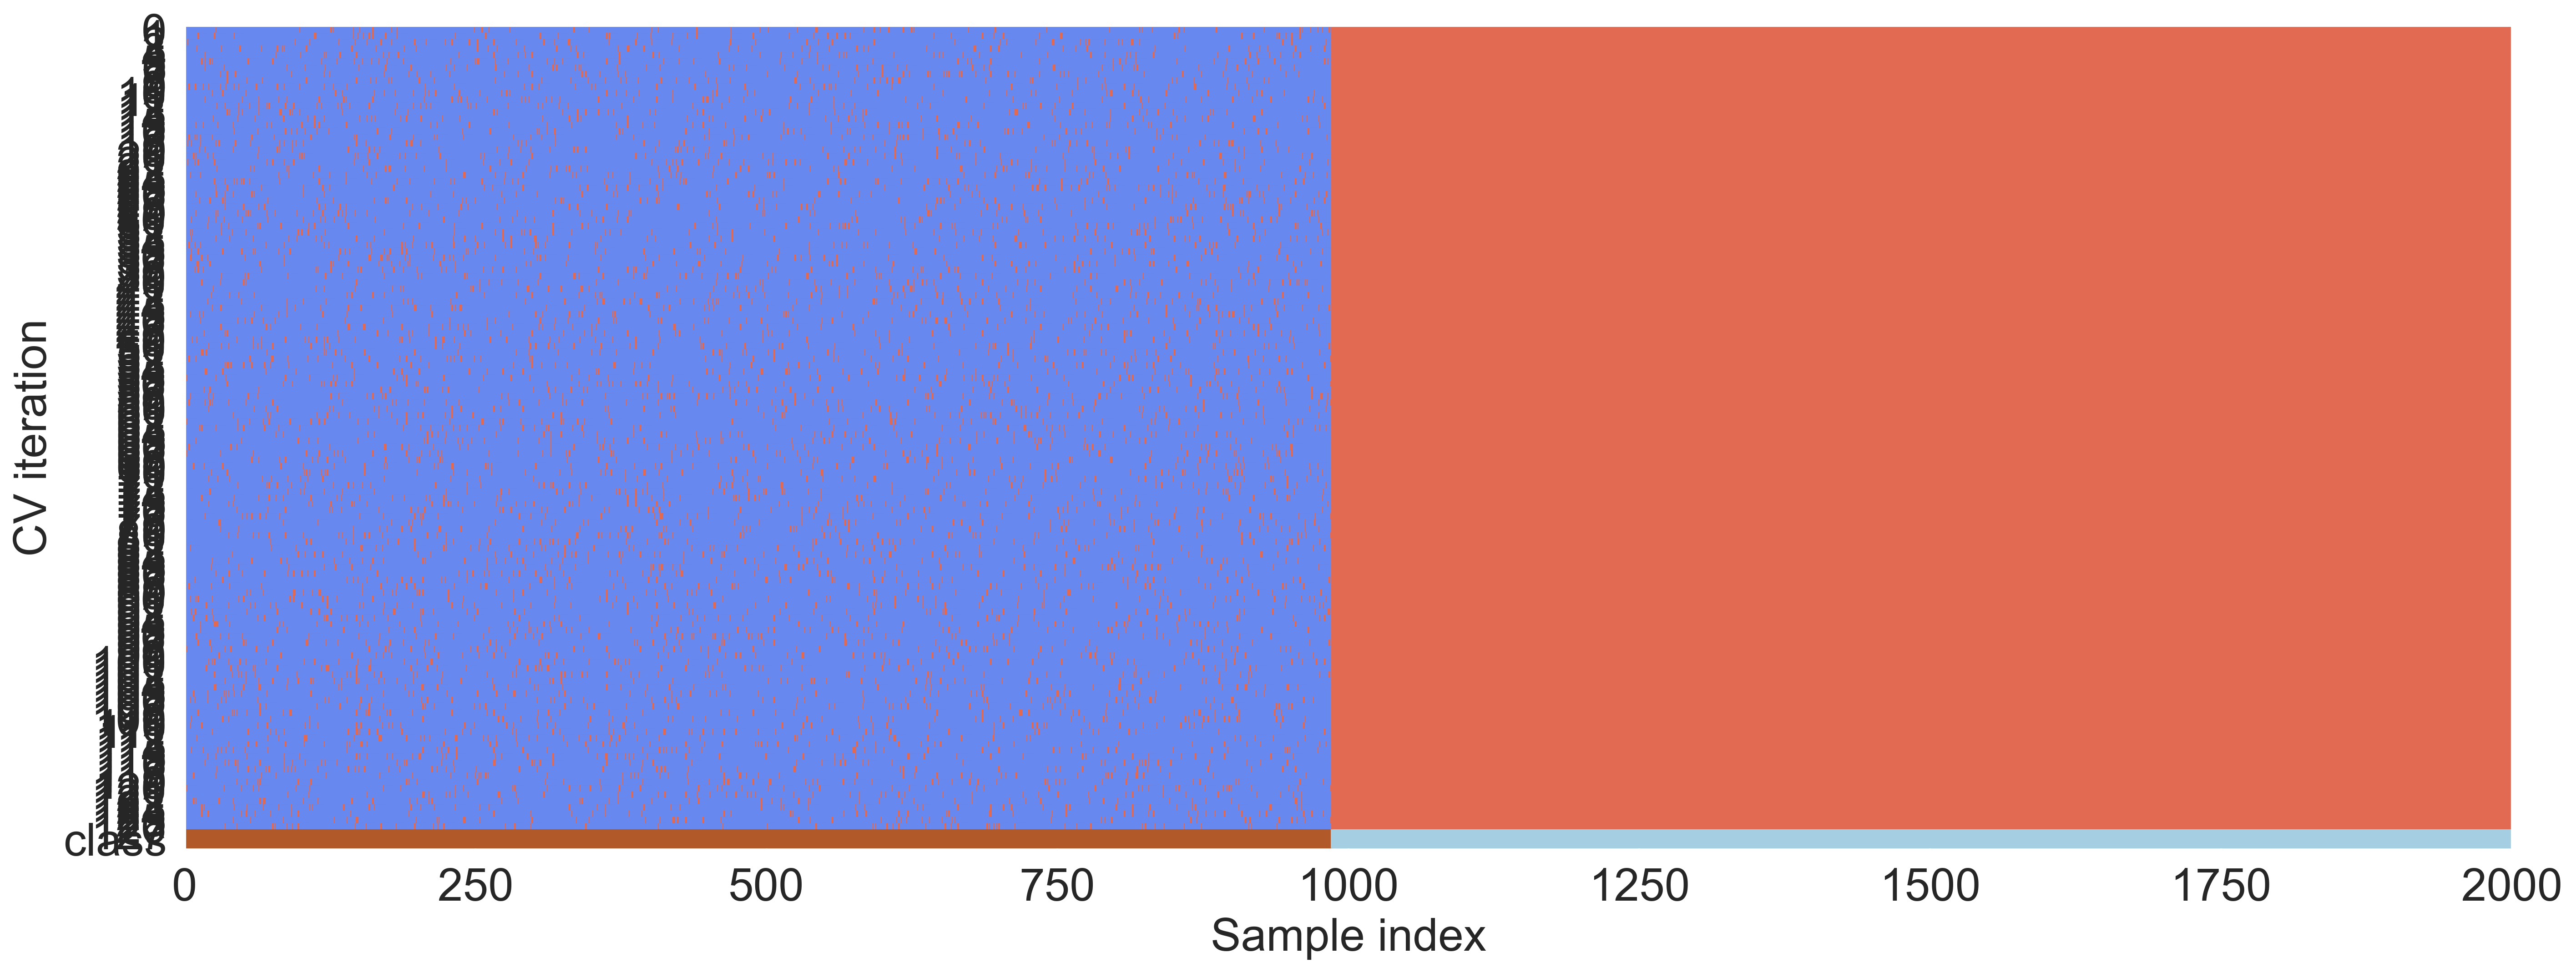

In [13]:
n_repeats = 1
cv = RepeatedAnomalyShuffleSplit(Xpos, Xneg, n_splits=128, test_size=.05, n_repeats=n_repeats, random_state=random_state)

for cv_ in cv:
    fig, ax = plt.subplots()
    ax = plot_cv_indices(cv_, X, y, ax)
    ax.set(xlim=[0, 2000])

# AB Testing

In [14]:
estimator = IsolationForest(contamination=0.03, n_estimators=100)
pipeline = Pipeline([('est', estimator)])

if_pipelines = repeat_experiment(estimator=pipeline, n_repeats=n_repeats, name="IsolationForest")

In [15]:
estimator = OneClassSVM(gamma='scale', nu=0.005)
pipeline = Pipeline([('est', estimator)])

svm_pipelines = repeat_experiment(estimator=pipeline, n_repeats=n_repeats, name="OneClassSVM")

In [16]:
estimator = EllipticEnvelope(contamination=0.14)
pipeline = Pipeline([('est', estimator)])

mcd_pipelines = repeat_experiment(estimator=pipeline, n_repeats=n_repeats, name="EllipticEnvelope")

In [17]:
svm_pipelines

[('OneClassSVM_0', Pipeline(steps=[('est', OneClassSVM(nu=0.005))]))]

In [18]:
if_pipelines

[('IsolationForest_0',
  Pipeline(steps=[('est', IsolationForest(contamination=0.03))]))]

In [19]:
mcd_pipelines

[('EllipticEnvelope_0',
  Pipeline(steps=[('est', EllipticEnvelope(contamination=0.14))]))]

In [20]:
results = aabb_classification_benchmark(X=X, y=y,
                                   models=[if_pipelines, svm_pipelines, mcd_pipelines],
                                   cv=cv,
                                   scoring=scoring,
                                   random_state=random_state)

## Store results for later

In [21]:
results.to_pickle(result_file)

## Plot some results for overview

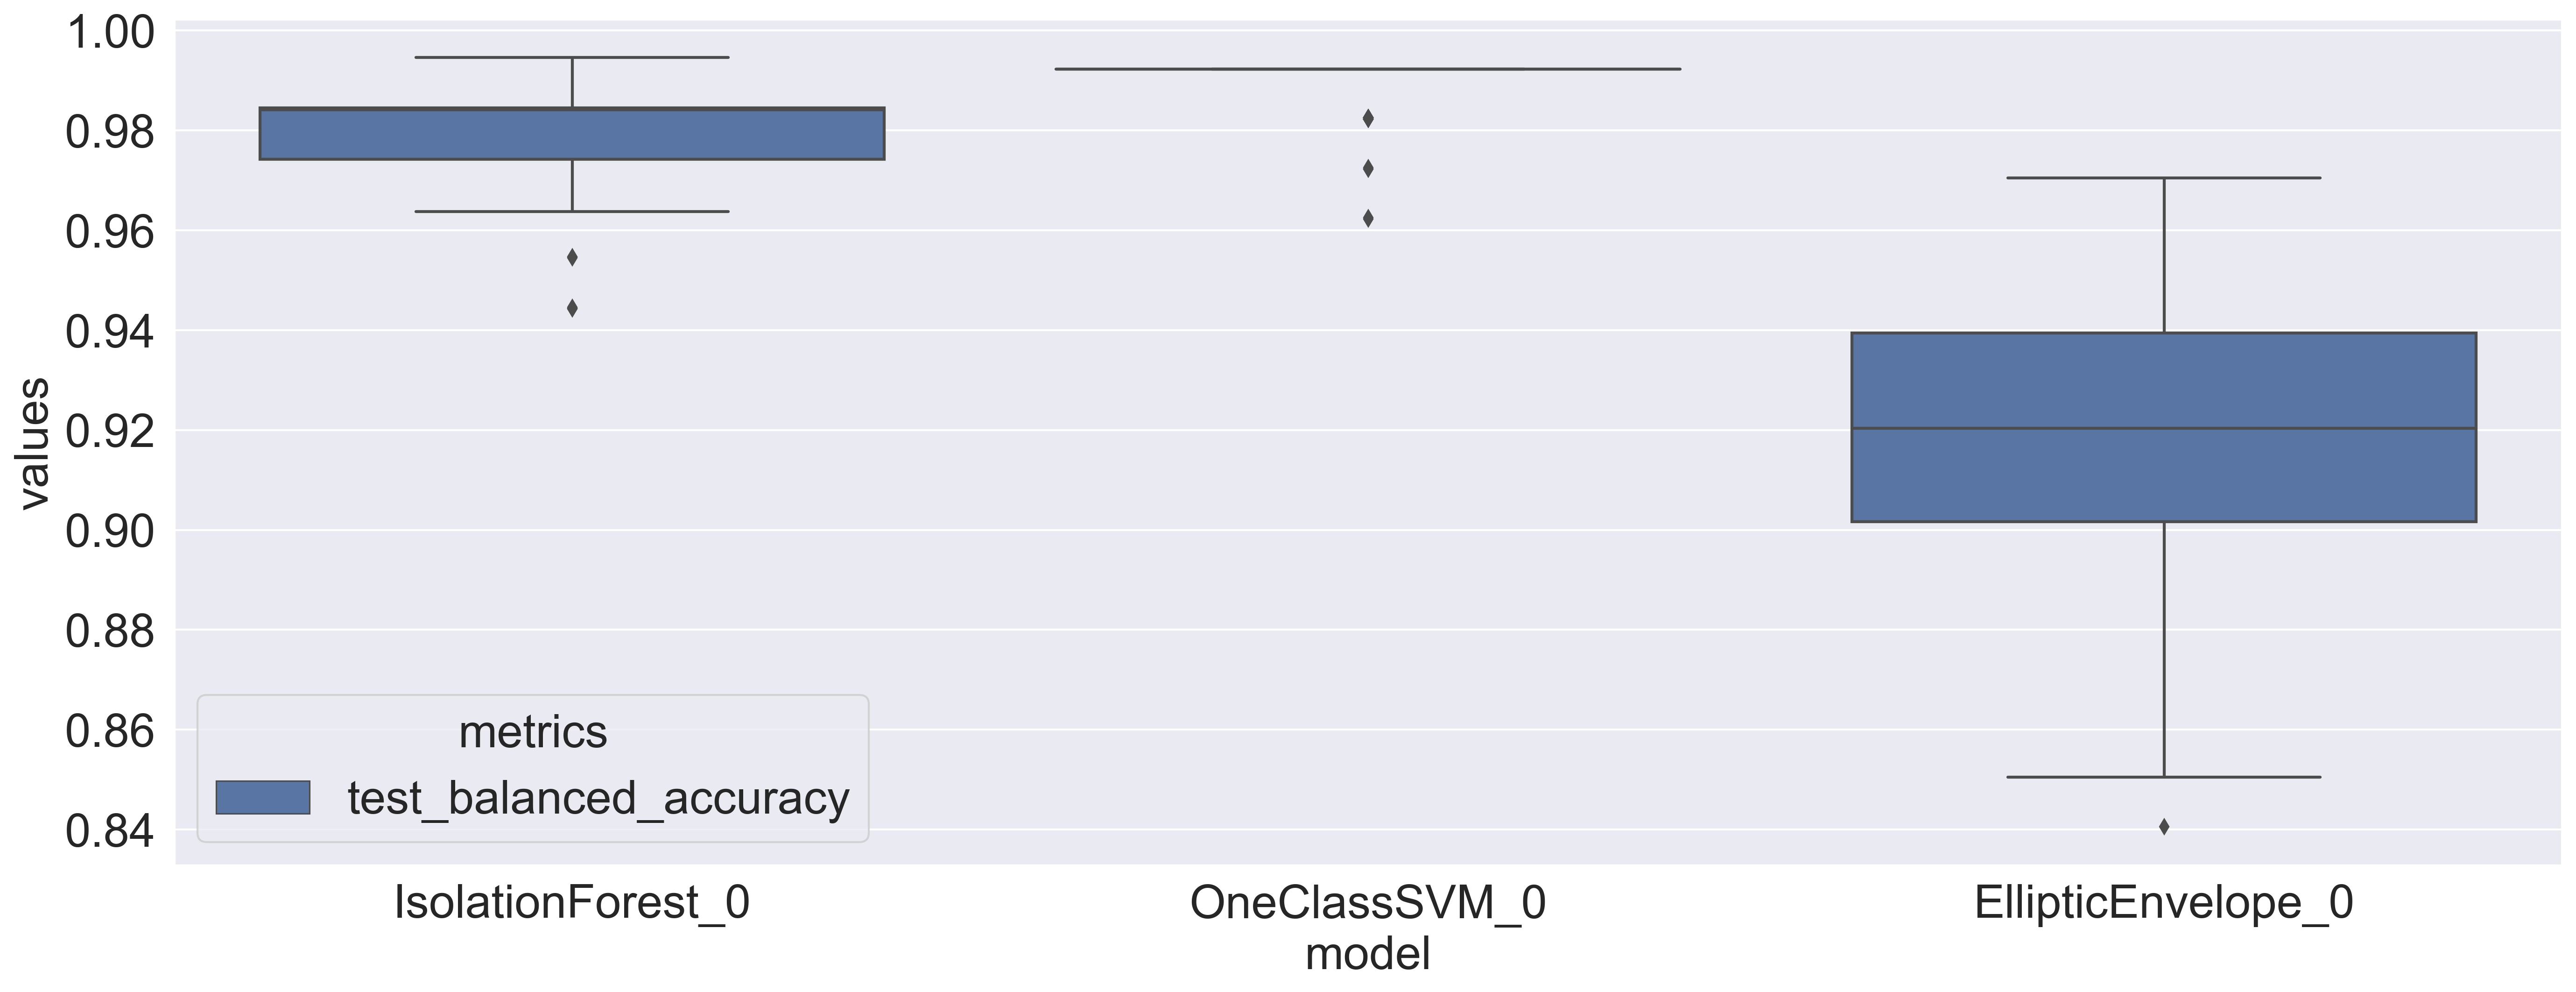

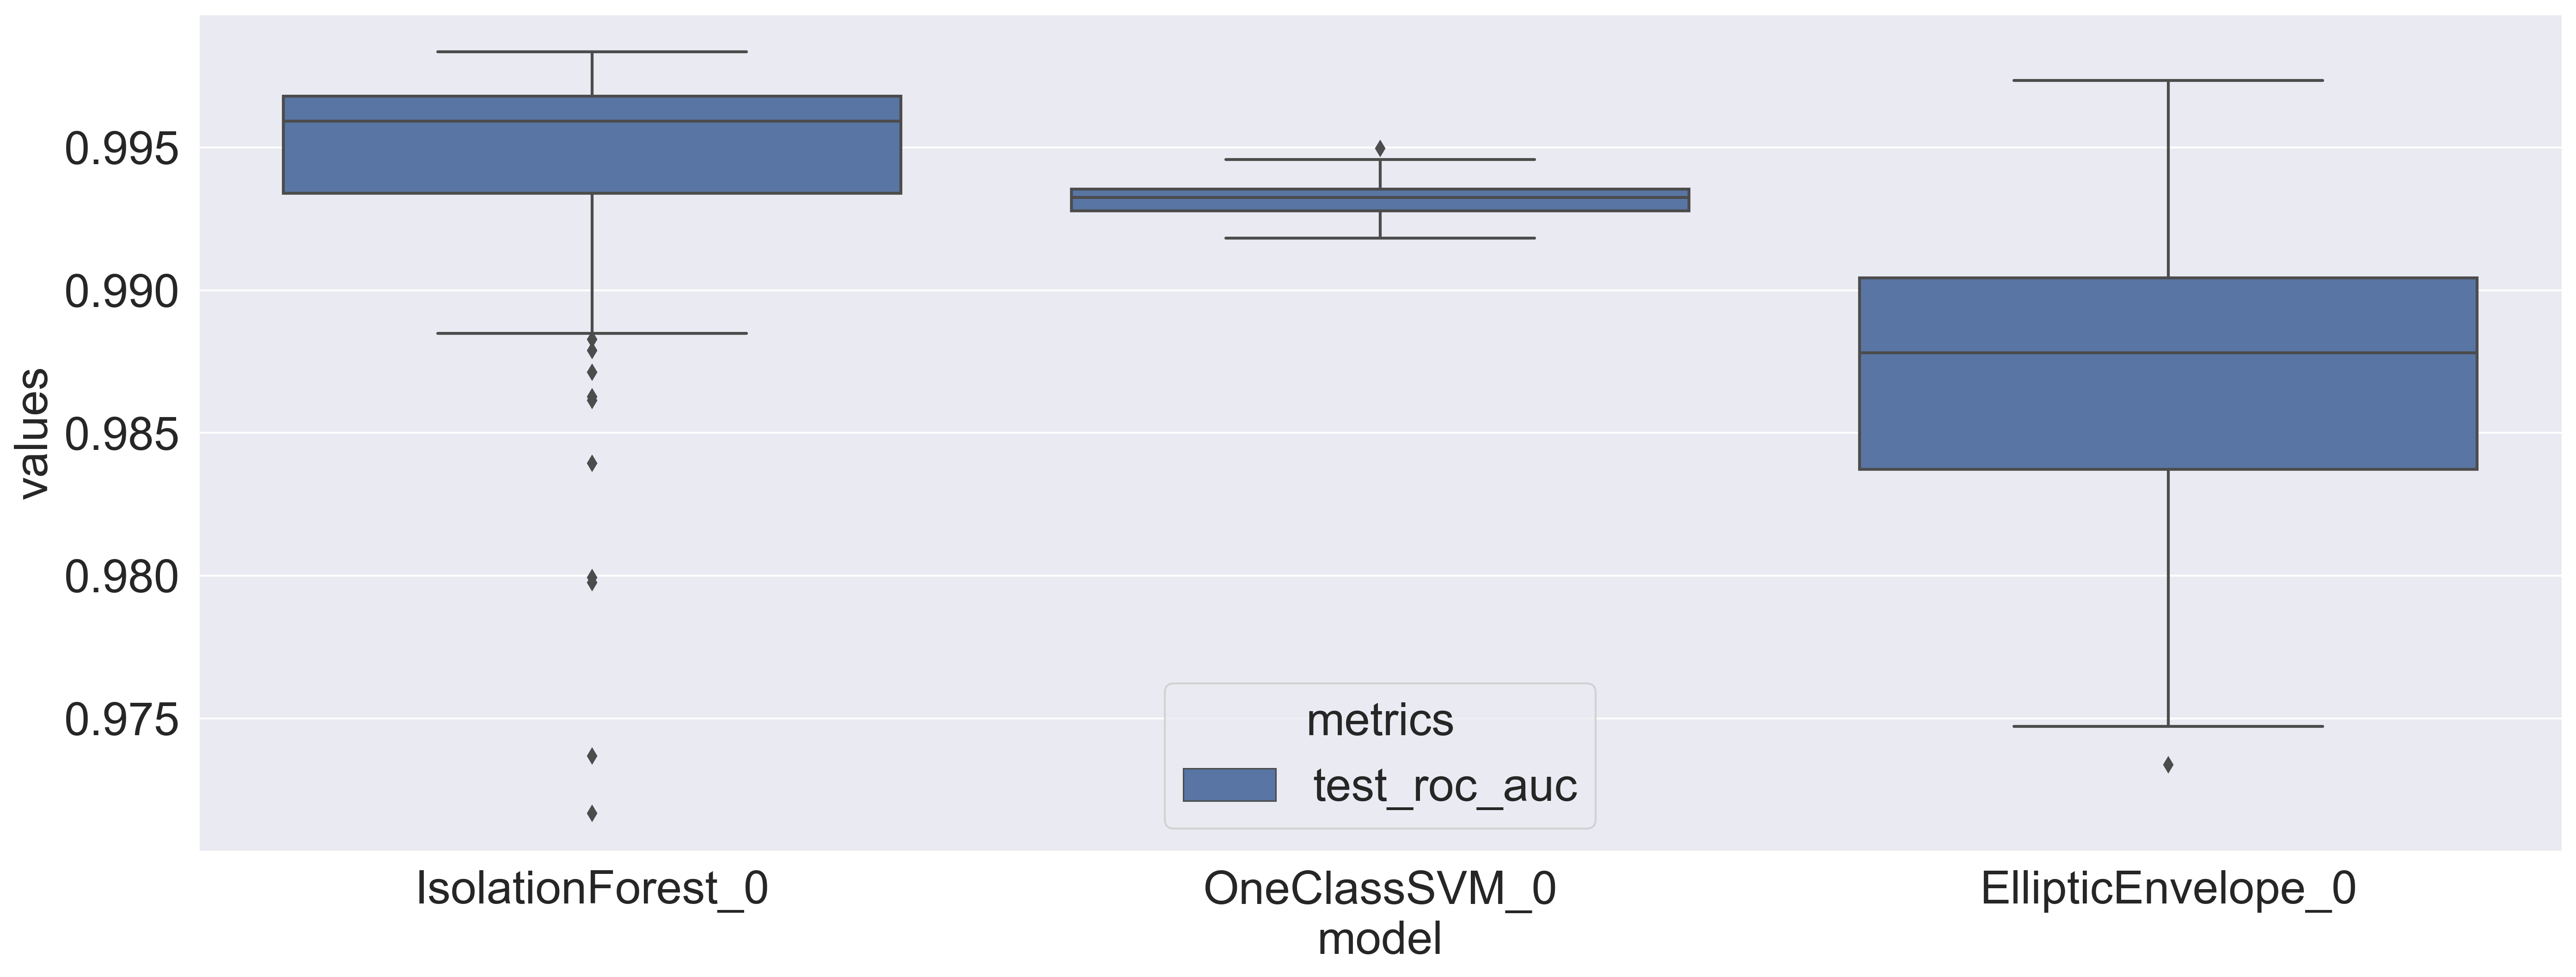

In [22]:
for key in results.columns[2:4]:
    fig = plot_metrics(extract_metrics(results, [key]))
    plt.show()